# Notebook 2: Quadratic-Leaky-Integrate-And-Fire-Neuron & Bifurkationen

**Computergestützte Biologie I -  SoSe 25**

Anian Kerscher

---

In **Notebook 1** haben wir gesehen, dass eine gewöhnliche DGL 1. Ordnung, wie das LI Neuron, nur mit zeitabhängigen Inputstrom oszilliert.  
Nun stellt sich die Frage: **Kann ein rein autonomes System 1. Ordnung trotzdem periodische Lösungen aufweisen?**  
Um dies zu untersuchen, betrachten wir das **Quadratic-Integrate-And-Fire (QIF)-Neuron** – ein nichtlineares, simples und klassisches Modell, das biologisch motivierte Spike-Mechanik enthält.

*Anmerkung*: Teilweise lässt sich die Erweiterung auch auf das LI Neuron anwenden.

In [ ]:
# some imports we need the code below - just run the cell

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# set plot defaults
from plot_defaults import set_matplotlib_defaults

set_matplotlib_defaults()

### Modellparameter
Zuerst definieren wir wieder passende Parameter für das Quadratic-Leaky-Integrate-And-Fire-Neuron.

In [5]:
def set_parameters():
    global a_0, g_l, eps_0, eps_r, d, c_m, tau_m
    global v_rest, v_crit, v_reset, radius, surface, c_abs
    global h, v_peak
    
    # [S/m^2] leak conductance (or 0.3 mS/cm^2)
    g_l = 0.3

    # [As/Vm] vacuum permittivity
    eps_0 = 8.854e-12 

    # relative permittivity
    eps_r = 4.518 

    # [nm] diameter of cell membrane
    d = 6.5e-9 

    # specific membrane capacitance (cap. per surface area) 
    #must be multiplied by surface area to get
    # absolute capacitance [F/m^2]
    c_m = eps_r * eps_0 / d 

    # membrane time constant [s] ususally between 10 and 100 ms
    tau_m = c_m / g_l
    
    # [V] resting potential of cell membrane
    v_rest = -0.065

    # [V] critical voltage for spike initiation
    v_crit = -0.055
    
    # reset voltage after spike
    v_reset = -0.070
    
    # maximum voltage of spike. If voltage reaches this value it 
    # is reset to v_reset
    v_peak = 0.0

    # [m] cell radius
    radius = 10.e-6 

    # [m^2] surface area of cell membrane 
    surface = 4. * np.pi * np.square(radius)  

    # [F] absolute capacitance of membrane
    c_abs = c_m * surface
    
    # time step
    h = 0.0001
    
    # model parameter of integrate and fire neuron
    a_0 = 40.

set_parameters()
print('τ =', np.round(tau_m, 5)) 

τ = 0.02051


In [9]:
v_crit

-0.055

### Quadratic-Integrate-and-Fire-Neuron
Das Quadratic-Integrate-And-Fire-Neuron wird durch folgende Gleichung beschrieben:

$$
c_m \dfrac{dV}{dt} - I_{in}(t) = g_l \cdot a_0(V-V_{rest})(V-V_{crit}), \quad a_0>0, \space V_{crit} > V_{rest} 
$$

Für ein realistisches Verhalten gilt zusätzlich:

$$
\text{wenn } V(t) > V_{peak}: V(t) \to V_{reset}
$$

**Geben Sie Art, Ordnung, Linearität, evtl. Homogenität sowie abhängige und unabhängige Variablen an. Unter welcher Bedingung ist das System autonom? Wie viele Randbedingungen werden zum Lösen benötigt? Nennen Sie ein Beispiel.**

<details>
<summary style="color: red; cursor: pointer;"><i>Lösung anzeigen/verbergen</i></summary>

Nicht lineare (somit kein Homogenitätskriterium), gewöhnliche DGL 1. Ordnung; $V$ abhängige, $t$ unabhängige Variable. Autonom wenn $I_{in}(t) = I_{ext} = const.$
    
    
1. Ordnung $\rightarrow$ eine Randbedinung, z.B. $V(t=0)=V_0$ (Anfangsbedingung).

</details>

**Bringen Sie die Gleichung in die dynamische Form, sodass diese numerisch gelöst werden kann ($f(V(t), t)$).**

<details>
<summary style="color: red; cursor: pointer;"><i>Lösung anzeigen/verbergen</i></summary>

Allgemeine Form lautet:
    
$$
\frac{dV}{dt} = f(V(t), t)
$$
    
Somit ergibt sich:
  
$$
\dfrac{dV}{dt} = \frac{g_l a_0}{c_m}(V-V_{rest})(V-V_{crit}) + \frac{I_{in}(t)}{c_m}, \quad a_0>0, \space V_{crit} > V_{rest} 
$$

</details>

**Welche drei Arten von Strömen exsitieren im QIF Neuron?**

<details>
<summary style="color: red; cursor: pointer;"><i>Lösung anzeigen/verbergen</i></summary>

- Kapazitiver Strom: $ I_{cap}(t) = c_m \frac{dV}{dt} $
 
- Elektroden Strom: (oder Synapse): $I_{el}(t) = I_{in}(t)$
    
- Leak Strom: $I_{leak}(t) = g_l a_0 (V-V_{rest})(V-V_{crit})$

</details>

### Aufgabe 1: Fixpunkte

Wir untersuchen, wie aus der Grundlagenvorlesung bekannt, die QIF DGL für konstanten Input $I_{in}(t) = 0$.

Gehen Sie dazu wie folgt vor:

- Definieren Sie eine Funktion `f_quad(v,t)` ($\overset{\wedge}{=}$ dynamische Form)
- Plotten Sie `f_quad(v,t)` mit den folgenden Parametern: \
`
current =  0. # pA
i_in = lambda t: current
v_min, v_max = -0.08, -0.04
v_vals = np.linspace(v_min, v_max, 1000)
t_val = 0
`

Bestimmen Sie visuel (ohne Rechnung):

- Lage der Fixpunkte und Stabilität. *Anmerkung:* Wer üben möchte, darf die Stabilitätsanalyse auch zuhause analytisch machen.

Zeichnen Sie (evtl. auch auf Papier) das **1D-Phase-Line Diagram**. Aus diesem sollte ebenfalls die Lage und Stabilität der Fixpunte ersichtlich sein.

In [78]:
def f_quad(v,t):
    """
    params:
    v: membrane potential at time t_n
    t: time point t_n
    
    
    further global variables used in this function:
    tau_m: membrane time constant
    a_0: model parameter
    g_l: membrane conductance
    v_rest: resting potential
    v_crit: crtitcal potential of qLIF-Neuron
    
    returns: dV/dt at time t_n, where dV/dt=f(V_n,t_n)
    """
    dvdt = '''TODO'''
    return  dvdt

In [1]:
##########################
# Set simulation parameters
set_parameters()
current =  0. # pA
i_in = lambda t: current
v_min, v_max = -0.08, -0.04
v_vals = np.linspace(v_min, v_max, 1000)
t_val = 0
##########################
# Print key parameters
print("QIF Neuron Parameters:")
print(f"  Leak conductance g_l:      {g_l:.2e} S/m²")
print(f"  Membrane capacitance c_m:  {c_m:.2e} F/m²")
print(f"  Time constant tau_m:       {tau_m:.2e} s")
print(f"  Resting potential:         {v_rest:.3f} V")
print(f"  Critical voltage:          {v_crit:.3f} V")
print(f"  a_0 (nonlinearity):        {a_0}")
print(f"  Cell surface area:         {surface:.2e} m²")
print(f"  Absolute capacitance:      {c_abs:.2e} F")

##########################
# Calculate y values, then plot

dVdt = 'TODO'

fig = plt.figure(figsize=(8, 5), dpi=300)

'TODO'

NameError: name 'set_parameters' is not defined

### Aufgabe 2: Numerische Lösung des QIF Neurons
Wenden Sie die Methode aus `Notebook 1` an, um das System numerisch zu lösen.

Gehen Sie dazu wie folgt vor:

Zusätzliche Parameter:

`
t_min, t_max = 0.,.1
v_0 = -0.1
t = np.arange(t_min, t_max, h)
`


- Übergeben Sie `f_quad` (aus Aufgabe 1), `v_0` und `t` and `odeint` aus dem scipy-modul zum Lösen der DGL. Optional können Sie auch die selbst verfasste Euler Methode mit passender Schrittweite implementieren.

Analysieren Sie anschließend:

- Verändern Sie die Anfangsbedingung $V(t=0) = V_0 = $ `v_0`. Verwenden Sie Werte zwischen $-100 mV$ und $0 mV$. Wie verändert sich der zeitliche Verlauf der Membranspannung abhängig vom Wert der Anfangsbedingung? Was passiert wenn Sie `v_0` z.B. auf -0.05 setzen (d.h. wohin entwickelt sich das System in diesem Fall (zumindest theoretisch) für $t \to \infty$)?
- Passen Sie ihr Lösungsverfahren an. Können Sie mit Ihrem neuen Lösungsverfahren oszillierende Lösungen erzeugen?

<details>
<summary style="color: red; cursor: pointer;"><i>Tipp anzeigen/verbergen</i></summary>

Wohin divergiert die Lösung theoretisch? Was ist das Problem dabei?

Von welcher zusätzlichen Bedingung ist oben im Text die Rede?
    
    
```python
    def solve(f_quad, v_0, t):
        # include a for loop that solves step by step between two timepoints (still using odeint) and 
        # using an if loop checks the final value
```

</details>

- Welche Bedeutung besitzt $a_0$? *Hinweis*: $\tau = c_m/g_l$ ist wie beim LIF Neuron die Zeitkonstante der Membran. 
- Welche Bedeutung haben $V_{crit} \text{ und } V_{rest}$ ?

<details>
<summary style="color: red; cursor: pointer;"><i>Lösung anzeigen/verbergen</i></summary>

- $a_0$ ist ein Parameter, welcher die Erregbarkeit des Neurons kontrolliert, indem es mit der Zeitkonstante multipliziert wird. Die Einheit ist $\frac{1}{V}$. *Anmerkung*: Für $a_0 = 40$ gilt näherungsweise: $a_0 (V-V_{crit}) \approx 1$. 
    
- $V_{crit}$: Threshold (Schwellenwert) für das Aktionspotential. Einheit ist V. Übersteigt das Membranpotential diesen Wert, kommt es zu einem Aktionspotetial (Peak bei $V_{peak}$, dann wird auf $V_{reset}$ zurückgesetzt).

- $V_{rest}$: Ruhemembranpotential [V]. Ein stabiler FP. Diesen Wert hat *V(t)* im Ruhezustand.

</details>

QIF Neuron Parameters:
  Leak conductance g_l:      3.00e-01 S/m²
  Membrane capacitance c_m:  6.15e-03 F/m²
  Time constant tau_m:       2.05e-02 s
  Resting potential:         -0.065 V
  Critical voltage:          -0.055 V
  a_0 (nonlinearity):        40.0
  Cell surface area:         1.26e-09 m²
  Absolute capacitance:      7.73e-12 F


ValueError: x and y must have same first dimension, but have shapes (1000,) and (1,)

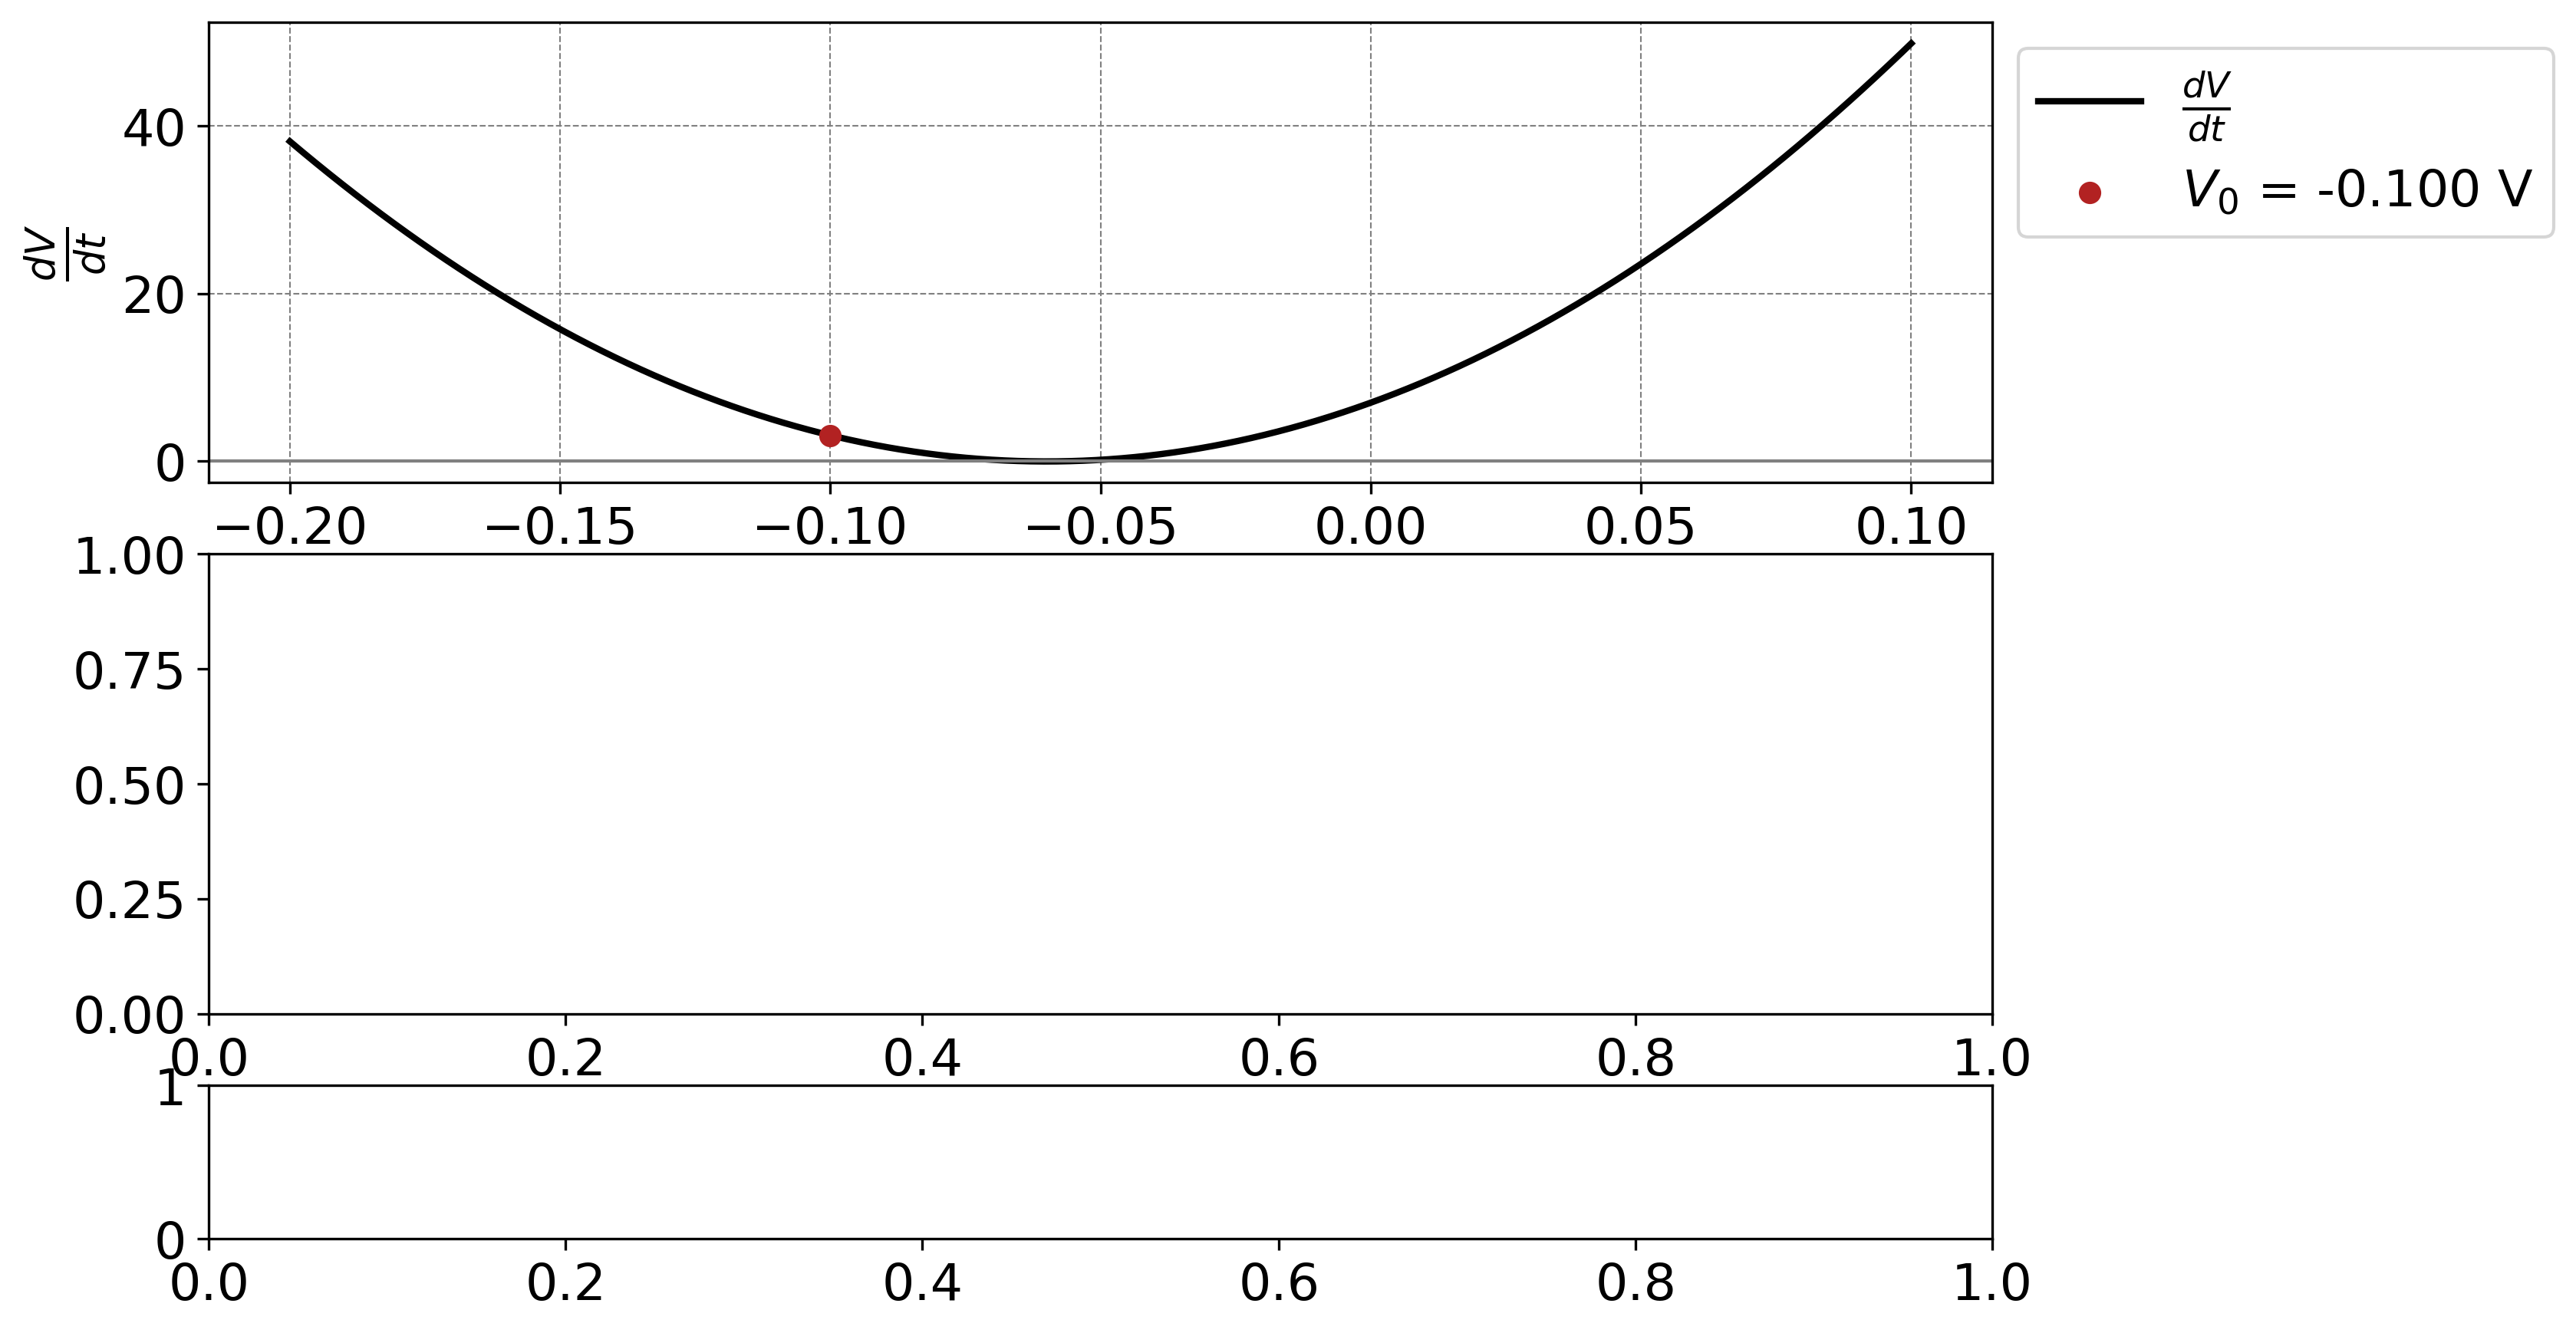

In [99]:
##########################
# set simulation parameters
set_parameters()
current =  0. # pA
i_in = lambda t: current
t_min, t_max = 0.,.1
v_0 = -.1 # TODO: Anfangsbedingung ändern
t = np.arange(t_min, t_max, h)
##########################
# run
v = 'TODO'

##########################
# Print key parameters
print("QIF Neuron Parameters:")
print(f"  Leak conductance g_l:      {g_l:.2e} S/m²")
print(f"  Membrane capacitance c_m:  {c_m:.2e} F/m²")
print(f"  Time constant tau_m:       {tau_m:.2e} s")
print(f"  Resting potential:         {v_rest:.3f} V")
print(f"  Critical voltage:          {v_crit:.3f} V")
print(f"  a_0 (nonlinearity):        {a_0}")
print(f"  Cell surface area:         {surface:.2e} m²")
print(f"  Absolute capacitance:      {c_abs:.2e} F")

##########################
V_range = np.linspace(-0.2, 0.1, 500)
dVdt = f_quad(V_range, 0)

fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(10, 7), dpi=300,
    gridspec_kw={'height_ratios': [3, 3, 1]}  # Phase, V(t), current
)

# Phase plot: dV/dt vs V
ax1.plot(V_range, dVdt, color='black', label=r'$\frac{dV}{dt}$')
ax1.scatter(v_0, f_quad(v_0, 0), color='firebrick', label=f'$V_0$ = {v_0:.3f} V', zorder=5)

ax1.axhline(0, color='gray', lw=1, ls='-')
ax1.set_xlabel(r'$V(t)$')
ax1.set_ylabel(r'$\frac{dV}{dt}$')
ax1.legend(loc='upper left', bbox_to_anchor = (1, 1))
ax1.grid(True)

# Time evolution plot: V(t)
ax2.plot(t, v, lw=1, color='firebrick', label=f'$V_0$ = {v_0:.3f} V')

ax2.set_ylabel(r'$V(t)$')
ax2.legend(loc='upper left', bbox_to_anchor = (1, 1))
ax2.grid(True)

# External current: I_in(t)
i_vals = [i_in(ti) for ti in t]
ax3.plot(t, i_vals, label=r'$I_{in}(t)$')
ax3.set_xlabel(r'$t$')
ax3.set_ylabel(r'$I_{in}(t)$')
ax3.legend(loc='upper left', bbox_to_anchor = (1, 1))
ax3.grid(True)

plt.tight_layout()
plt.show()


##########################
# reset parameters
set_parameters()

### Aufgabe 3: Bifurkationen

Was genau ist eine Bifurkation?

<details>
<summary style="color: red; cursor: pointer;"><i>Lösung anzeigen/verbergen</i></summary>

Eine Bifurkation beschriebt eine qualitative Änderung des Phasenportraits (z.B. bistabil -> monostabil). Dies geschieht durch die Änderung eines Bifurkationswerts (NICHT abhängige oder unabhängige Variable). Der Bifurkationswert trennt somit zwei qualitativ unterschiedliche Regime. 

</details>


- Visualisierten Sie wieder $f(V(t), t)$ nun für verschiedene konstante Elektrodenströme $I_{in}(t)$ (unseren Bifurkationsparameter). Wie verändert sich die Lage der Fixpunkte? Wie muss $I_{in}$ gewählt werden, sodass ein Fixpunkt verschwindet?

- Berechnen Sie den Bifurkationspunkt exakt. Wie ändert sich das Verhalten des Systems am Punkt der Bifurkation? Erklären Sie.

- Überprüfen Sie ihr Ergebnis in einer Computersimulation! Setzen Sie dazu die Stromstärke auf den berechneten Wert  für die Bifurkation und variieren die Spannung zwischen -0.062 und -0.058V. Erklären Sie das Verhalten.

- Um welche Bifurkation handelt es sich? Können sie ein Bifurkationsdiagram erstellen? Wie sieht es mit periodischen Lösungen aus?

- Wie verändert sich der zeitliche Verlauf der Spannung, wenn sie die Stromstärke weiter in kleinen Schritten erhöhen? Was geschieht wenn Sie die Stromstärke verringern?



In [2]:
'TODO'
# plot aus Aufgabe 1 modifizieren.

'TODO'

### Optional: Aufgabe 4: Feuerrate
Messen Sie die Feuerrate (Aktionspotentiale pro Zeit) abhängig von der Stromstärke bei einem konstanten Eletrodenstrom für 50 verschiedene Stromstärken. Tragen Sie die Feuerrate als Funktion Stromstärke in einem xy-Diagramm gegen einander auf! Wo befindet sich der Bifurkationspunkt?

Hinweis: Messen Sie die Anzahl der Aktionspotentiale anhand der Ausschläge nach unten! Wie viele Elemente des Arrays haben den Wert -0.070 ($V_{reset}$)?

In [29]:
# Hinweis: Anzahl der Aktionspotentiale
n_APs = np.sum(v == v_reset)
n_APs

1

In [3]:
i_in = lambda t: np.ones(np.shape(t))*400.0e-6
v_0 = -0.060
t = np.arange(t_min, 10., h)

v=solve(f_quad, v_0, t)
i_cap = compute_capacitive_current(v,t)


##########################
# display results
fig = plt.figure(dpi=150, figsize=(5,3))

ax1 = fig.add_subplot(211)
ax1.plot(t, v, 'k-')
#ax1.set_xlabel('time [s]')
ax1.set_xlabel('')
ax1.set_xticklabels([])
ax1.set_ylabel('membrane\n voltage\n [V]')

ax2 = fig.add_subplot(212)
ax2.plot(t, i_cap*1.e12, 'k-')
#ax2.plot(t, i_in(t), 'y--', lw=1.)
ax2.set_xlabel('time [s]')
ax2.set_ylabel('capacitive\n current\n[$pA$]')
# cut negative values
ylims = ax2.get_ylim()
#ax2.set_ylim([-0.1*ylims[1], ylims[1]])
#ax2.set_ylim([-0.05, 0.05])

plt.show()

set_parameters()
print("Action potential count:", np.sum(v == v_reset))

NameError: name 'np' is not defined